# Import basic package and Setting basic functions

In [1]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
pi = np.pi

In [2]:
def solve_coeff_with_3_methods():
    sampler = SimulatedAnnealingSampler()  # for test

    tra_a0_dict = {}
    for M in M_set:
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)

    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_2D(v, h, tao, freq_max, L=20)
        wang_a0_dict["Wang" + f" M={M}"] = linear_sys.solve(
            M=M,
            alpha=1,
            beta=1,
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            solver=cholesky_solver,
            show_process=False,
        )

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_2D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M) / 100,  # initial vector of Delta a
            num_sample=100,  # 5000
            R=8,
            alpha=1.0,
            beta=0.7,
            fixed_point=0,
            epsilon=1e-6,
            maxiter=10,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
            num_spin_reversal_transforms=10,
            postprocess=True,
        )
        qa_a0 = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            epsilon=1e-8,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
            show_process=False,
        )
        qa_a0_dict[f"QA M={M}"] = qa_a0

    result_dict = dict(ChainMap(tra_a0_dict, wang_a0_dict, qa_a0_dict))
    return result_dict, linear_sys

## set plot function

In [9]:
def show_disp_curve(result_dict):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

    lw = 1.1  # linwidth of box
    style_set = ["-", "--", ":"]
    linwith = 1.2
    counter = 0
    for label, coeff in result_dict.items():
        for str_theta, theta in zip(["0", "$\\pi/8$", "$\\pi/4$"], [0, pi / 8, pi / 4]):
            sigma = linear_sys.cal_sigma(
                v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff, theta=theta
            )
            if "Tra" in label:
                ax[0].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="maroon",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="Tra" + "  " + f"$\\theta=${str_theta}",
                )
            elif "QA" in label:
                ax[0].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="midnightblue",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="QA" + "  " + f"$\\theta=${str_theta}",
                )
            counter = (counter + 1) % 3
    ax[0].set_ylim([0.9, 1.05])
    ax[0].set_xlim([0, 3.142])
    ax[0].set_ylabel("$\delta(\\theta)$", fontsize=12)
    ax[0].set_xlabel("$kh$", fontsize=12)
    ax[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
    # 设置边框粗细
    ax[0].spines["left"].set_linewidth(lw)
    ax[0].spines["top"].set_linewidth(lw)
    ax[0].spines["right"].set_linewidth(lw)
    ax[0].spines["bottom"].set_linewidth(lw)

    # 设置主刻度格式
    ax[0].tick_params(
        top=True,
        right=True,
        which="major",
        direction="in",
        length=4,
        width=1.0,
        colors="black",
        labelsize=8,
    )
    # 设置次刻度格式
    ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))  # 显示子刻度,括号里的是间距
    ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
    # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
    ax[0].tick_params(
        top=True,
        right=True,
        direction="in",
        which="minor",
        length=2,
        width=0.8,
        colors="black",
    )

    ax[0].grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
    ax[0].legend(
        title="",
        fontsize="x-small",
        loc="lower left",
        borderpad=1.0,  # 图例内部留白
        borderaxespad=2.0,  # 图框边界距离坐标轴距离
        labelspacing=0.5,  # 图例条目间距
        edgecolor="black",
        handlelength=2.5,
    )
    ax[0].text(
        x=-0.5,
        y=1.055,
        s="(a)",
        fontfamily="Arial",
        fontsize=13,
        fontweight="bold",
    )


    counter = 0
    for label, coeff in result_dict.items():
        for str_theta, theta in zip(["0", "$\\pi/8$", "$\\pi/4$"], [0, pi / 8, pi / 4]):
            sigma = linear_sys.cal_sigma(
                v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff, theta=theta
            )
            if "Wang" in label:
                ax[1].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="maroon",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="Wang" + "  " + f"$\\theta=${str_theta}",
                )
            elif "QA" in label:
                ax[1].plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color="midnightblue",
                    linewidth=linwith,
                    ls=style_set[counter],
                    label="QA" + "  " + f"$\\theta=${str_theta}",
                )
            counter = (counter + 1) % 3
    ax[1].set_ylim([0.9, 1.05])
    ax[1].set_xlim([0, 3.142])
    ax[1].set_ylabel("$\delta(\\theta)$", fontsize=12)
    ax[1].set_xlabel("$kh$", fontsize=12)
    ax[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    ax[1].set_yticks([0.9, 0.95, 1.0, 1.05])
    # 设置边框粗细
    ax[1].spines["left"].set_linewidth(lw)
    ax[1].spines["top"].set_linewidth(lw)
    ax[1].spines["right"].set_linewidth(lw)
    ax[1].spines["bottom"].set_linewidth(lw)

    # 设置主刻度格式
    ax[1].tick_params(
        top=True,
        right=True,
        which="major",
        direction="in",
        length=4,
        width=1.0,
        colors="black",
        labelsize=8,
    )
    # 设置次刻度格式
    ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))  # 显示子刻度,括号里的是间距
    ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
    # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
    ax[1].tick_params(
        top=True,
        right=True,
        direction="in",
        which="minor",
        length=2,
        width=0.8,
        colors="black",
    )

    ax[1].grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
    ax[1].legend(
        title="",
        fontsize="x-small",
        loc="lower left",
        borderpad=1.0,  # 图例内部留白
        borderaxespad=2.0,  # 图框边界距离坐标轴距离
        labelspacing=0.5,  # 图例条目间距
        edgecolor="black",
        handlelength=2.5,
    )

    ax[1].text(
        x=-0.5,
        y=1.055,
        s="(b)",
        fontfamily="Times New Roman",
        fontsize=13,
        fontweight="bold",
    )
    return fig, ax

## low speed

Current object function value is 4948.236401514648
~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[22.2514468  10.85948075 -9.80600028  4.34211828 -2.14614665 -0.40946264
   1.52523664 -7.27878819  1.51006562  3.72705131]]
Current object function value is 3864132903.5525165
~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[11.39139117  5.19829864 -4.69889974  2.00306959 -0.9438403  -0.29726657
   0.82214634 -3.67178533  0.7712383   1.8539444 ]]
Current object function value is 240992535.16038337
~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 6.1751541   2.18538677 -1.98490945  0.70269882 -0.24209026 -0.31218241
   0.51626485 -1.89184972  0.41398128  0.90987171]]
Current object function value is 14935860.725388346
~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 3.76873097  0.52806302 -0.49708924 -0.047458    0.18526513 -0.3678819
   0.39421781 -1.0105296   0.24199193  0.43188532]]
Current object function value is 903674.6062261682
~~~~~~~

d:\OneDrive\OneDrive - mails.ucas.ac.cn\Research\2_Monthly_Report\2024博三下半学期\博士期间第一篇工作\code_for_the_paper\Solution_of_Forward_Operator\core\QUBO_solvers.py:629: UserWarning: 'codingMod' indicates the way bit string to represent a number! It contain three mod, 'p', 'n', 'pn' If not specified, the default Settings will be used
  warnings.warn(



* The sampling time in 1 iteration was: 0.36 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.37103007672506033
* The step size of current iteration:1.0319345739258419

* The sampling time in 2 iteration was: 0.42 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.34206437757126235
* The step size of current iteration:0.4346011769932392

* The sampling time in 3 iteration was: 0.38 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.15567566087644139
* The step size of current iteration:0.308231752959645

* The sampling time in 4 iteration was: 0.36 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.11434977865900159
* The step size of current iteration:0.20320838444711328

* The sampling time in 5 iteration was: 0.33 s
** The postprocess time is: 0.008 s
* Current Object Function is 0.0609184585943779
* The step size of current iteration:0.11240002382208446

* The sampling time in 6 iteration was: 0.31 s
** The 

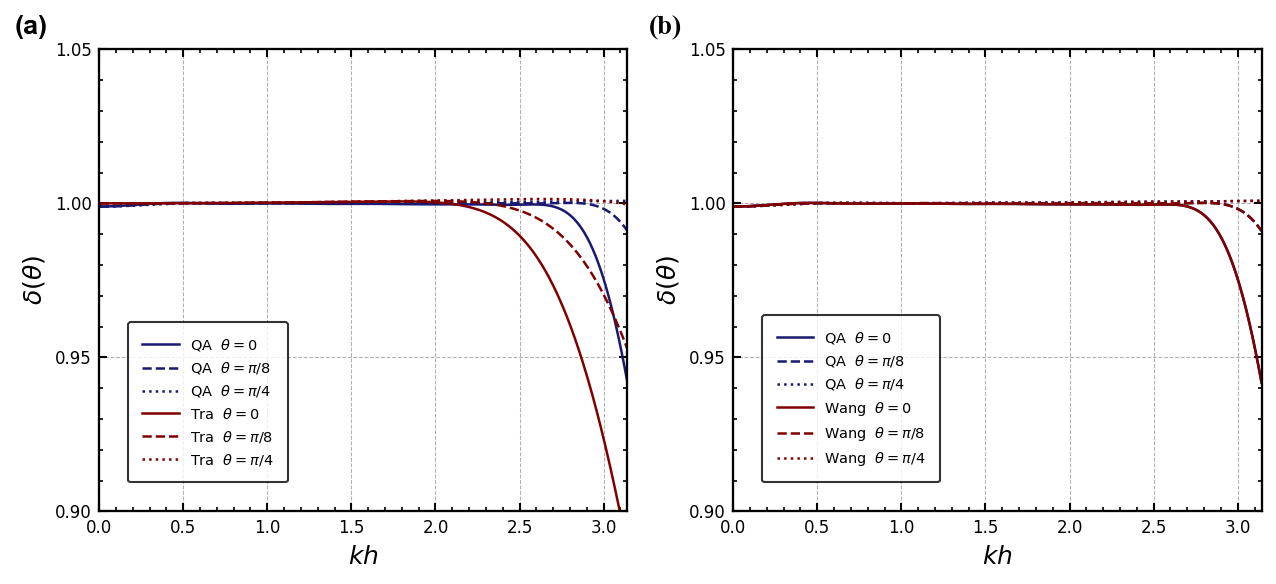

In [4]:
v = 1500
h = 20
tao = 0.001
freq_max_set = [32]
M_set = [10]
max_iter_num = 20

result_dict, linear_sys = solve_coeff_with_3_methods()
fig, ax = show_disp_curve(result_dict)
# fig.savefig("2D_low_velocity_reuslt.png", dpi=300)
# fig.savefig("2D_low_velocity_reuslt.pdf", dpi=600, format="pdf")

## high speed

Current object function value is 3556.4182523389404
~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[17.93391343 11.14606473 -8.67219285  2.77036302 -0.65935944 -1.46045029
   2.09932431 -7.09285528  1.87929724  3.10328108]]
Current object function value is 2072807992.330297
~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 9.12642381  5.44631859 -4.22820493  1.30428121 -0.27020553 -0.76574223
   1.0706433  -3.5512541   0.94257379  1.54945367]]
Current object function value is 129223626.02336164
~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 4.87572415  2.47558314 -1.90342547  0.49428265 -0.01911354 -0.45207412
   0.57615146 -1.78483139  0.47692463  0.77038792]]
Current object function value is 7995613.819177385
~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 3.0120071   0.7890891  -0.57095118 -0.03700285  0.19866115 -0.34948148
   0.36043114 -0.90691964  0.2478833   0.37693169]]
Current object function value is 480313.0727810724
~~~~~~~

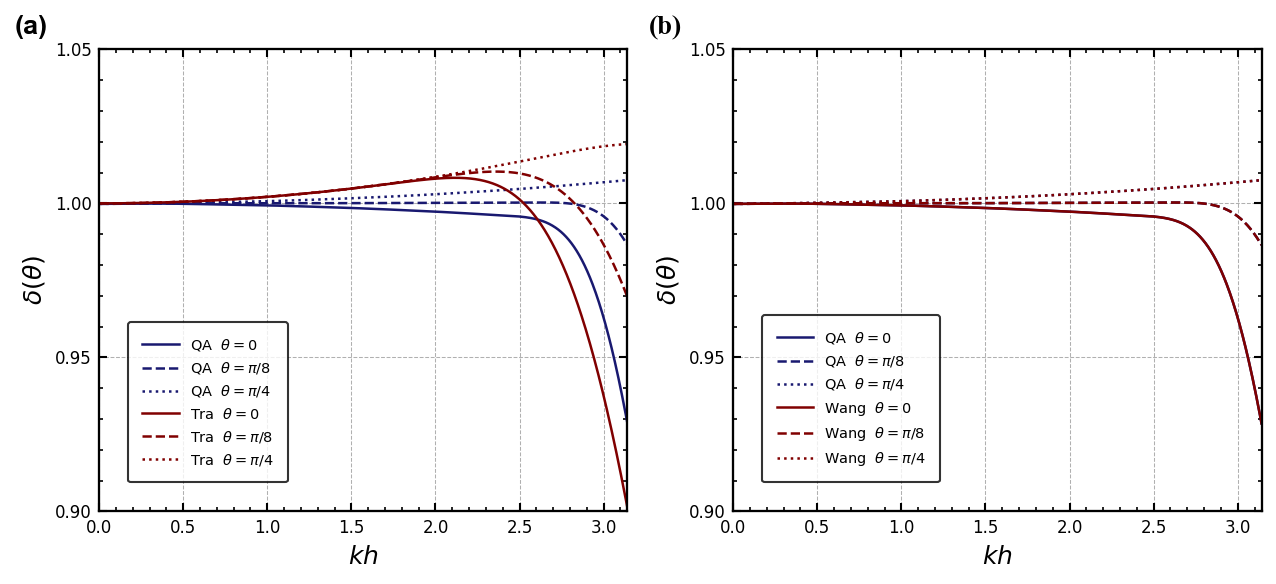

In [5]:
v = 4500
h = 20
tao = 0.001
freq_max_set = [90]
M_set = [10]
max_iter_num = 20
result_dict, linear_sys = solve_coeff_with_3_methods()
fig, ax = show_disp_curve(result_dict)
# fig.savefig("2D_high_velocity_reuslt.png", dpi=300)
# fig.savefig("2D_high_velocity_reuslt.pdf", dpi=600, format="pdf")